In [1]:
import sys, os

# add TriplePandelReco directory to $PYTHONPATH.
sys.path.insert(0, "/home/storage/hans/jax_reco_gupta_corrections3")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# load jax and make sure we use double precision
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
# also need quick access to normal distribution
from jax.scipy.stats import norm as jnorm
from jax.scipy.stats.norm import pdf as norm_pdf
from jax.scipy.stats.norm import logpdf as norm_logpdf
from jax.scipy.special import logsumexp

# import network logic.
from lib.gupta_network_eqx_4comp import get_network_eval_fn

# import some required coordinate transformations
# see e.g. https://github.com/HansN87/TriplePandelReco_JAX/blob/gupta_4comp/dom_track_eval.py 
# for how these would be used in practice during reconstruction
from lib.trafos import transform_network_inputs
from lib.trafos import transform_network_outputs_gupta_4comp as transform_network_outputs

# import pdf and cdf of mixture of gupta distributions.
from lib.gupta import multi_gupta_pdf
from lib.gupta import multi_gupta_cdf
from lib.gupta import c_multi_gupta_mpe_prob_quad
from lib.gupta import log_pdf, log_sf

# we also want some plotting and other standard libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# generate network evaluation logic (gupta with 4 components) based on weights from TriplePandelReco data directory
# again: double precision.
dtype = jnp.float64

path_to_reco = '/home/storage/hans/jax_reco_gupta_corrections3/'

eval_network = get_network_eval_fn(bpath=os.path.join(path_to_reco, 'data/gupta/n96_4comp/new_model_no_penalties_tree_start_epoch_800.eqx'), dtype=dtype, n_hidden=96)

In [24]:
# here are some coordinates
#dist = 30.0 # m

dist = 5.0
z = -500.0 # m
rho = 0.0 # radians
zenith = jnp.pi/2 # radians
azimuth = 0.0 # radians

x = jnp.array([dist, rho, z, zenith, azimuth])

# which we can now map to our pdf parameters (4-comp gupta) via the neural network
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gupta_a, gupta_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

Text(0.5, 0, 'delay time [ns]')

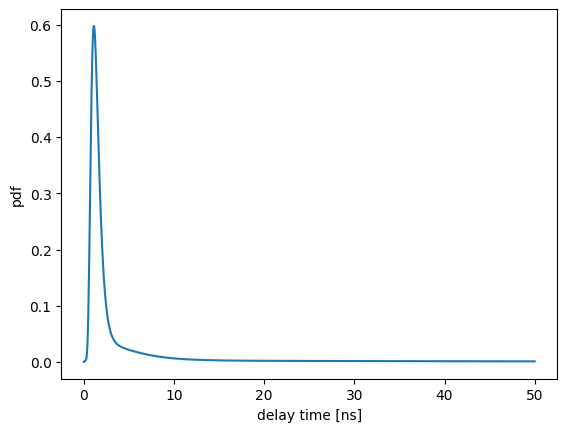

In [25]:
# make a plot of the gupta pdf for the chosen coordinates

delay_times = jnp.linspace(0.0, 50.0, 1000)
plt.plot(delay_times, multi_gupta_pdf(delay_times, mix_probs, gupta_a, gupta_b))
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")

In [26]:
def c_multi_gupta_mpe_logprob_midpoint2_stable_large_sigma(x, log_mix_probs, a, b, n, sigma=3.0):
    """
    Q < 30
    """
    nmax = 3
    eps = 1.e-6

    int_scale = 1

    x0 = eps
    x_m0 = 0.01
    xvals0 = jnp.linspace(x0, x_m0, 10 * int_scale)[:-1]

    x_m1 = 0.05
    xvals1 = jnp.linspace(x_m0, x_m1, 10 * int_scale)[:-1]

    x_m2 = 0.25
    xvals2 = jnp.linspace(x_m1, x_m2, 10 * int_scale)[:-1]

    x_m25 = 0.75
    xvals25 = jnp.linspace(x_m2, x_m25, 10 * int_scale)[:-1]

    x_m3 = 2.5
    xvals3 = jnp.linspace(x_m25, x_m3, 10 * int_scale)[:-1]

    x_m4 = 8.0
    xvals4 = jnp.linspace(x_m3, x_m4, 20 * int_scale)

    xmin = jnp.max(jnp.array([1.5 * eps, x - nmax * sigma * int_scale]))
    xmax = jnp.max(jnp.array([xmin+1.5*eps, x + nmax * sigma * int_scale]))
    xvals_x = jnp.linspace(xmin, xmax, 101 * int_scale)

    xvals = jnp.sort(jnp.concatenate([xvals0, xvals1, xvals2, xvals25, xvals3, xvals4, xvals_x]))

    dx = xvals[1:]-xvals[:-1]

    xvals = 0.5*(xvals[:-1]+xvals[1:])
    log_n_pdf = norm_logpdf(xvals, loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    log_mix_probs_e = jnp.expand_dims(log_mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    log_pdfs = logsumexp(log_pdf(xvals_e, a_e, b_e) + log_mix_probs_e, 0)
    log_sfs = logsumexp(log_sf(xvals_e, a_e, b_e) + log_mix_probs_e, 0)

    return logsumexp(log_n_pdf + log_pdfs + (n-1) * log_sfs + jnp.log(dx) + jnp.log(n), 0)

c_multi_gupta_mpe_logprob_midpoint2_stable_large_sigma_v = jax.jit(jax.vmap(c_multi_gupta_mpe_logprob_midpoint2_stable_large_sigma, (0, None, None, None, None, None), 0))

Text(0.5, 0, 'delay time [ns]')

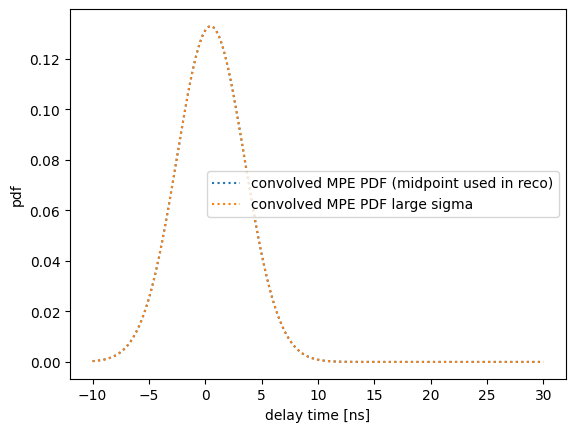

In [27]:
# Let's compare both version (numeric integration and midpoint) to what we use during reconstruction (another midpoint)
from lib.gupta import c_multi_gupta_mpe_logprob_midpoint2_stable
c_multi_gupta_mpe_logprob_midpoint2_stable_v = jax.jit(jax.vmap(c_multi_gupta_mpe_logprob_midpoint2_stable, (0, None, None, None, None, None), 0))

delay_times = jnp.linspace(-10.0, 30.0, 1000) # note: we now allow negative times
# reminder: the original PDF does not have support for negative values.

# assume 100 photons
n_p = jnp.array(100)
# and 3ns convolution
sigma = jnp.array(3.0)

ys_conv_midpoint = jnp.exp(c_multi_gupta_mpe_logprob_midpoint2_stable_large_sigma_v(delay_times, jnp.log(mix_probs), gupta_a, gupta_b, n_p, sigma)) # numeric conv via midpoint
ys_conv_midpoint2 = jnp.exp(c_multi_gupta_mpe_logprob_midpoint2_stable_v(delay_times, jnp.log(mix_probs), gupta_a, gupta_b, n_p, sigma)) # numeric conv via midpoint
plt.plot(delay_times, ys_conv_midpoint2, label='convolved MPE PDF (midpoint used in reco)', linestyle='dotted')
plt.plot(delay_times, ys_conv_midpoint, label='convolved MPE PDF large sigma', linestyle='dotted')

plt.legend()
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")


Text(0.5, 0, 'delay time [ns]')

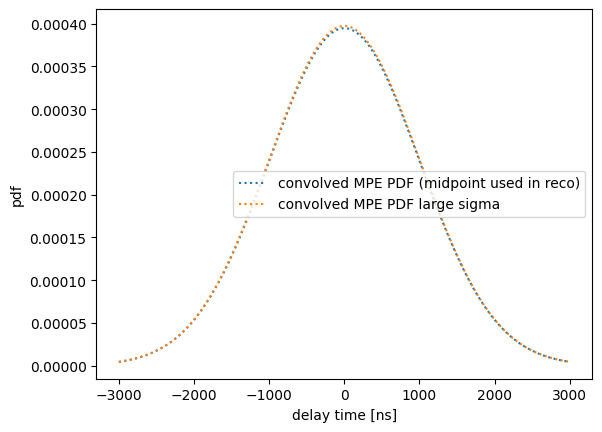

In [28]:
# Let's compare both version (numeric integration and midpoint) to what we use during reconstruction (another midpoint)
from lib.gupta import c_multi_gupta_mpe_logprob_midpoint2_stable
c_multi_gupta_mpe_logprob_midpoint2_stable_v = jax.jit(jax.vmap(c_multi_gupta_mpe_logprob_midpoint2_stable, (0, None, None, None, None, None), 0))

delay_times = jnp.linspace(-3000, 3000.0, 1000) # note: we now allow negative times
# reminder: the original PDF does not have support for negative values.

# assume 100 photons
n_p = jnp.array(2)
# and 3ns convolution
sigma = jnp.array(1000.0)

ys_conv_midpoint = jnp.exp(c_multi_gupta_mpe_logprob_midpoint2_stable_large_sigma_v(delay_times, jnp.log(mix_probs), gupta_a, gupta_b, n_p, sigma)) # numeric conv via midpoint
ys_conv_midpoint2 = jnp.exp(c_multi_gupta_mpe_logprob_midpoint2_stable_v(delay_times, jnp.log(mix_probs), gupta_a, gupta_b, n_p, sigma)) # numeric conv via midpoint
plt.plot(delay_times, ys_conv_midpoint2, label='convolved MPE PDF (midpoint used in reco)', linestyle='dotted')
plt.plot(delay_times, ys_conv_midpoint, label='convolved MPE PDF large sigma', linestyle='dotted')

plt.legend()
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")


In [29]:
jnp.sum(ys_conv_midpoint2 * (delay_times[1]-delay_times[0]))


Array(0.9868729, dtype=float64)

In [30]:
jnp.sum(ys_conv_midpoint * (delay_times[1]-delay_times[0]))


Array(0.99409293, dtype=float64)